In [3]:
# Install required libraries
!pip install -q xgboost scikit-learn imbalanced-learn pandas numpy matplotlib seaborn tensorflow kaggle

# Verify installations
import xgboost as xgb
import sklearn
import tensorflow as tf
print(f"XGBoost version: {xgb.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"TensorFlow version: {tf.__version__}")

XGBoost version: 3.1.0
Scikit-learn version: 1.6.1
TensorFlow version: 2.19.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
import os
project_dir = '/content/drive/MyDrive/IDS_Research'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/models', exist_ok=True)
os.makedirs(f'{project_dir}/results', exist_ok=True)
print(f"Project directory created at: {project_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project directory created at: /content/drive/MyDrive/IDS_Research


In [7]:
# Upload your kaggle.json file or create it
# Download from: https://www.kaggle.com/settings -> API -> Create New Token

from google.colab import files
import os

# Upload kaggle.json
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)
print("Kaggle API configured successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


In [11]:
# Download the dataset
!kaggle datasets download -d dhoogla/csecicids2018 -p /content/drive/MyDrive/IDS_Research/data --unzip

# List downloaded files
import os
data_dir = '/content/drive/MyDrive/IDS_Research/data'
print("Downloaded files:")
for file in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file)
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  {file}: {size_mb:.2f} MB")

Dataset URL: https://www.kaggle.com/datasets/dhoogla/csecicids2018
License(s): CC-BY-NC-SA-4.0
 98% 595M/604M [00:04<00:00, 121MB/s]
100% 604M/604M [00:04<00:00, 134MB/s]
Downloaded files:
  Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet: 79.61 MB
  Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet: 72.89 MB
  DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet: 85.35 MB
  DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet: 31.90 MB
  DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet: 94.05 MB
  DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet: 55.31 MB
  Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet: 48.59 MB
  Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet: 27.93 MB
  Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet: 99.14 MB
  Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet: 96.69 MB


DATA PREPARATION - PARQUET FILES

Found 10 Parquet files:
  Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet: 79.61 MB
  Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet: 72.89 MB
  DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet: 85.35 MB
  DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet: 31.90 MB
  DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet: 94.05 MB
  DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet: 55.31 MB
  Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet: 48.59 MB
  Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet: 27.93 MB
  Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet: 99.14 MB
  Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet: 96.69 MB

INITIAL EXPLORATION

Sample shape: (771587, 78)
Columns: ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd P

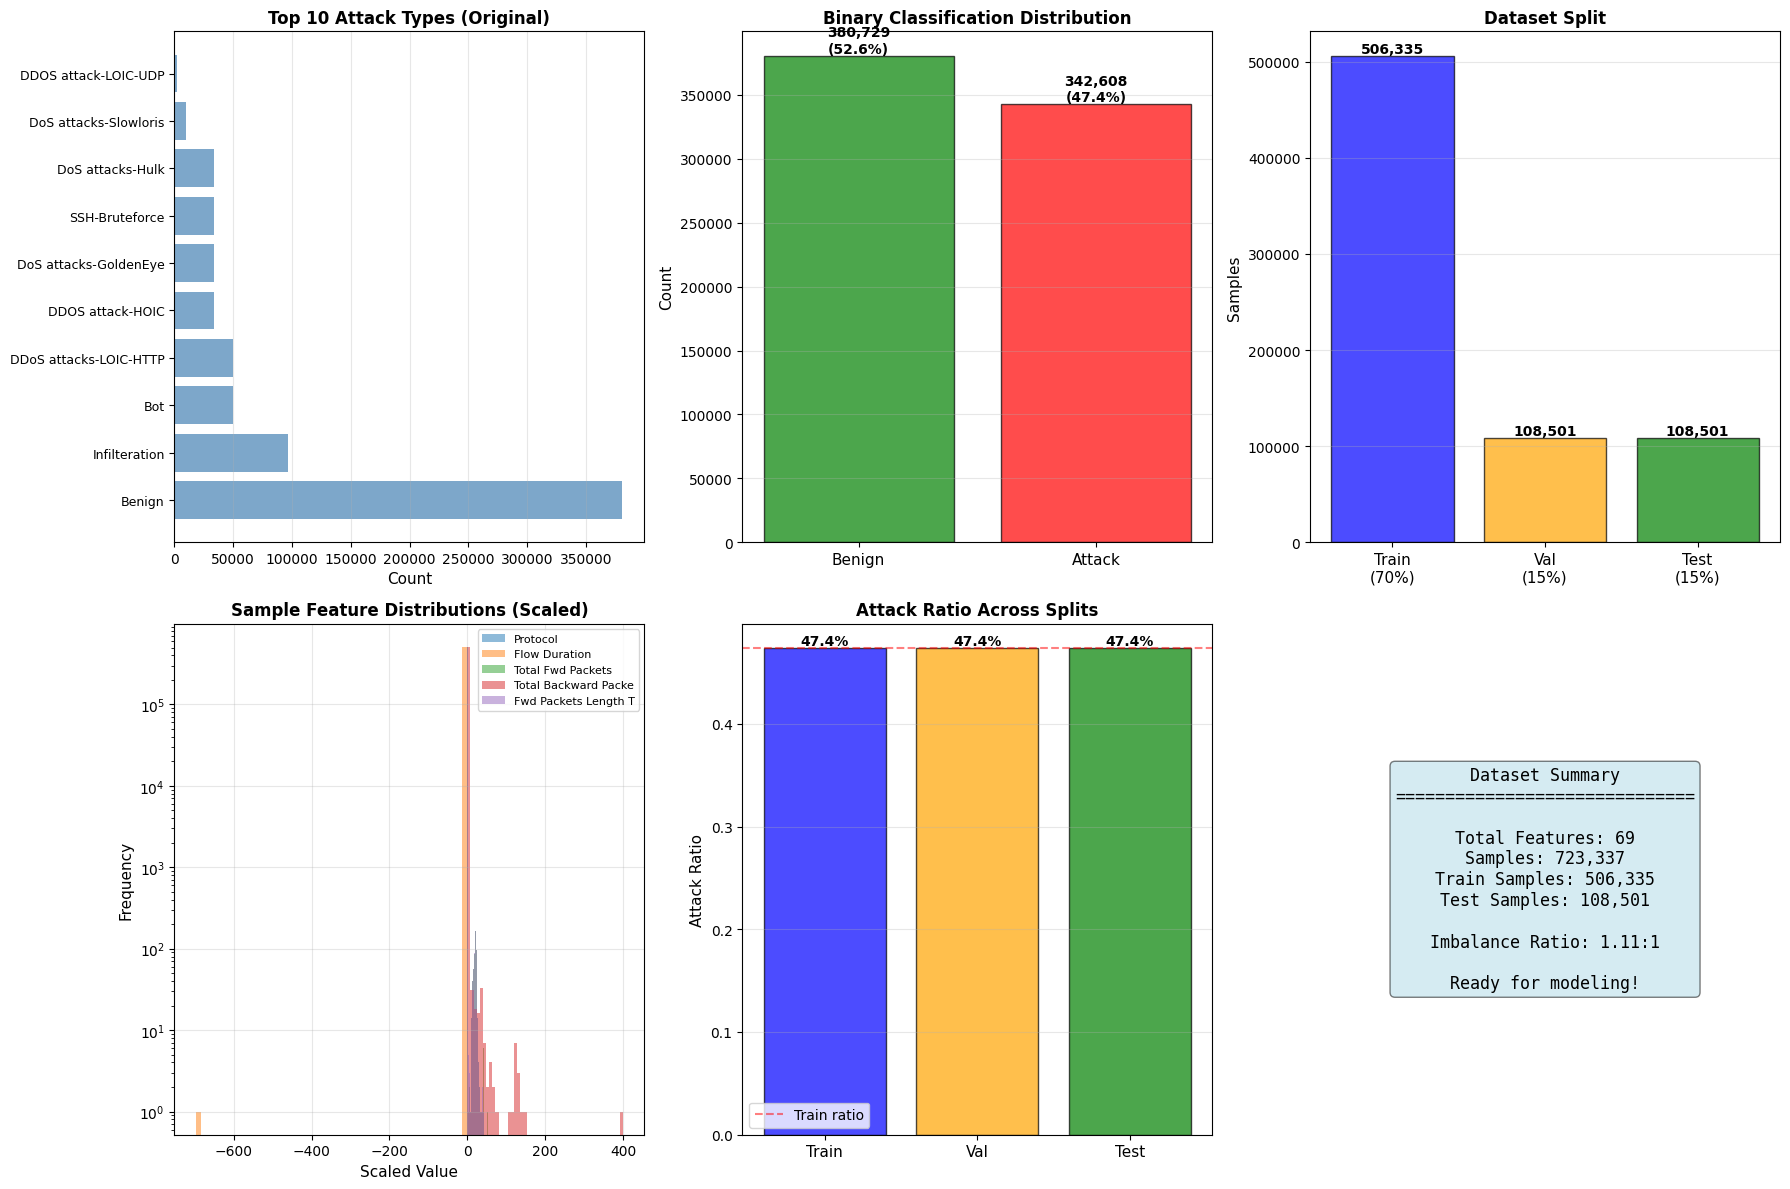


DATA PREPARATION COMPLETE!

You can now proceed to model training:
  1. XGBoost Implementation
  2. Random Forest Baseline
  3. CNN-LSTM Deep Learning Model


In [12]:
# Updated Data Preparation and Preprocessing for Parquet Files
# CSE-CIC-IDS-2018 Dataset - Parquet Format

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DATA PREPARATION - PARQUET FILES")
print("="*80)

# ============================================================================
# STEP 1: LOAD AND EXPLORE PARQUET FILES
# ============================================================================

data_dir = '/content/drive/MyDrive/IDS_Research/data'

# List all parquet files
parquet_files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
print(f"\nFound {len(parquet_files)} Parquet files:")
for file in parquet_files:
    file_path = os.path.join(data_dir, file)
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  {file}: {size_mb:.2f} MB")

# Load first file for exploration
print(f"\n{'='*80}")
print("INITIAL EXPLORATION")
print(f"{'='*80}\n")

df_sample = pd.read_parquet(os.path.join(data_dir, parquet_files[0]))
print(f"Sample shape: {df_sample.shape}")
print(f"Columns: {df_sample.columns.tolist()}")

# Identify label column
label_candidates = ['Label', 'label', 'Attack', 'attack', 'Class', 'class']
label_col = None
for candidate in label_candidates:
    if candidate in df_sample.columns:
        label_col = candidate
        break

if label_col is None:
    label_col = df_sample.columns[-1]
    print(f"\nAssuming last column '{label_col}' is the label")
else:
    print(f"\nLabel column identified: '{label_col}'")

print(f"\nLabel distribution (sample):")
print(df_sample[label_col].value_counts())

# ============================================================================
# STEP 2: SMART DATA LOADING STRATEGY
# ============================================================================

def load_parquet_files_smart(data_dir, max_samples_per_file=None,
                             balance_classes=True, random_state=42):
    """
    Smart loading strategy for large parquet files

    Parameters:
    - data_dir: directory with parquet files
    - max_samples_per_file: max samples to load per file (None = all)
    - balance_classes: whether to balance attack types
    - random_state: random seed

    Returns:
    - Combined DataFrame
    """
    parquet_files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
    dfs = []

    print(f"\n{'='*80}")
    print("LOADING PARQUET FILES")
    print(f"{'='*80}\n")

    for i, file in enumerate(parquet_files, 1):
        print(f"Loading file {i}/{len(parquet_files)}: {file}")
        df = pd.read_parquet(os.path.join(data_dir, file))

        # Sample if needed
        if max_samples_per_file and len(df) > max_samples_per_file:
            if balance_classes:
                # Sample proportionally from each class
                df = df.groupby(label_col, group_keys=False).apply(
                    lambda x: x.sample(min(len(x), max_samples_per_file // df[label_col].nunique()),
                                     random_state=random_state)
                )
            else:
                df = df.sample(n=max_samples_per_file, random_state=random_state)
            print(f"  Sampled to {len(df):,} rows")
        else:
            print(f"  Loaded {len(df):,} rows")

        dfs.append(df)

    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\n{'='*80}")
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"Total rows: {combined_df.shape[0]:,}")
    print(f"Total columns: {combined_df.shape[1]}")
    print(f"{'='*80}\n")

    return combined_df

# Load data with smart sampling
# Adjust max_samples_per_file based on your memory constraints
# For Google Colab: 100000-200000 is reasonable
# For full dataset: set to None (but may take long time)

print("Loading strategy options:")
print("1. Full dataset (may be slow/memory intensive)")
print("2. Balanced sample (recommended for experimentation)")
print("\nChoosing: Balanced sample with 100K samples per file\n")

df = load_parquet_files_smart(
    data_dir,
    max_samples_per_file=100000,  # Adjust based on your needs
    balance_classes=True,
    random_state=42
)

# Display label distribution
print(f"Label distribution in loaded data:")
label_dist = df[label_col].value_counts()
print(label_dist)
print(f"\nPercentages:")
for label, count in label_dist.items():
    print(f"  {label}: {count:,} ({count/len(df)*100:.2f}%)")

# ============================================================================
# STEP 3: DATA CLEANING AND PREPROCESSING
# ============================================================================

print(f"\n{'='*80}")
print("DATA CLEANING")
print(f"{'='*80}\n")

def clean_dataframe(df, label_col):
    """Clean and prepare dataframe"""
    df = df.copy()

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Strip whitespace from string columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()

    print(f"Initial shape: {df.shape}")

    # Remove duplicates
    initial_len = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_len - len(df):,} duplicate rows")

    # Separate features and labels
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Handle infinite values
    print(f"\nHandling infinite values...")
    inf_counts = {}
    for col in X.select_dtypes(include=[np.number]).columns:
        inf_count = np.isinf(X[col]).sum()
        if inf_count > 0:
            inf_counts[col] = inf_count
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)

    if inf_counts:
        print(f"Found infinite values in {len(inf_counts)} columns")
        print(f"Total infinite values: {sum(inf_counts.values()):,}")
    else:
        print("No infinite values found")

    # Handle missing values
    print(f"\nHandling missing values...")
    missing_before = X.isnull().sum().sum()

    if missing_before > 0:
        print(f"Total missing values: {missing_before:,}")

        # Impute numerical columns with median
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        imputer = SimpleImputer(strategy='median')
        X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

        # Drop remaining non-numeric columns with missing values
        X = X.dropna(axis=1)

        missing_after = X.isnull().sum().sum()
        print(f"Missing values after imputation: {missing_after:,}")
    else:
        print("No missing values found")

    # Remove constant columns (zero variance)
    print(f"\nRemoving constant features...")
    constant_cols = []
    for col in X.columns:
        if X[col].nunique() <= 1:
            constant_cols.append(col)

    if constant_cols:
        print(f"Found {len(constant_cols)} constant columns")
        X = X.drop(columns=constant_cols)
    else:
        print("No constant columns found")

    # Remove high-cardinality categorical columns
    print(f"\nChecking categorical columns...")
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"Found {len(categorical_cols)} categorical columns")
        for col in categorical_cols:
            unique_ratio = X[col].nunique() / len(X)
            if unique_ratio > 0.5:  # More than 50% unique values
                print(f"  Dropping high-cardinality column: {col}")
                X = X.drop(columns=[col])
            else:
                # Label encode categorical columns
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                print(f"  Label encoded: {col}")

    print(f"\nFinal feature count: {X.shape[1]}")
    print(f"Final sample count: {X.shape[0]:,}")

    return X, y

# Clean the data
X, y = clean_dataframe(df, label_col)

# ============================================================================
# STEP 4: CREATE BINARY LABELS
# ============================================================================

print(f"\n{'='*80}")
print("LABEL ENCODING")
print(f"{'='*80}\n")

# Create binary classification (Benign vs Attack)
# Adjust the benign label name based on your dataset
benign_labels = ['Benign', 'BENIGN', 'benign', 'Normal', 'NORMAL', 'normal']
benign_label = None

for label in benign_labels:
    if label in y.unique():
        benign_label = label
        break

if benign_label:
    y_binary = (y != benign_label).astype(int)
    print(f"Benign label identified: '{benign_label}'")
else:
    # If no benign label found, assume first label is benign
    most_common_label = y.value_counts().index[0]
    y_binary = (y != most_common_label).astype(int)
    print(f"Warning: No standard benign label found")
    print(f"Assuming most common label is benign: '{most_common_label}'")

print(f"\nBinary label distribution:")
print(f"  Benign (0): {(y_binary == 0).sum():,} ({(y_binary == 0).sum()/len(y_binary)*100:.2f}%)")
print(f"  Attack (1): {(y_binary == 1).sum():,} ({(y_binary == 1).sum()/len(y_binary)*100:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = (y_binary == 0).sum() / max((y_binary == 1).sum(), 1)
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

# Also keep multi-class labels for later analysis
le_multiclass = LabelEncoder()
y_multiclass = le_multiclass.fit_transform(y)

print(f"\nMulti-class labels:")
for i, label in enumerate(le_multiclass.classes_):
    count = (y_multiclass == i).sum()
    print(f"  {i}: {label} - {count:,} samples")

# ============================================================================
# STEP 5: TRAIN-TEST SPLIT
# ============================================================================

print(f"\n{'='*80}")
print("TRAIN-TEST SPLIT")
print(f"{'='*80}\n")

# Split: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary,
    test_size=0.3,
    random_state=42,
    stratify=y_binary
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nClass distribution:")
print(f"Training - Attack ratio:   {y_train.sum()/len(y_train)*100:.2f}%")
print(f"Validation - Attack ratio: {y_val.sum()/len(y_val)*100:.2f}%")
print(f"Test - Attack ratio:       {y_test.sum()/len(y_test)*100:.2f}%")

# ============================================================================
# STEP 6: FEATURE SCALING
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE SCALING")
print(f"{'='*80}\n")

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform all sets
print("Fitting scaler on training data...")
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")
print(f"\nScaled data statistics:")
print(f"  Mean: {X_train_scaled.mean().mean():.6f}")
print(f"  Std:  {X_train_scaled.std().mean():.6f}")
print(f"  Min:  {X_train_scaled.min().min():.2f}")
print(f"  Max:  {X_train_scaled.max().max():.2f}")

# ============================================================================
# STEP 7: SAVE PROCESSED DATA (OPTIONAL)
# ============================================================================

print(f"\n{'='*80}")
print("SAVING PROCESSED DATA")
print(f"{'='*80}\n")

# Create directory for processed data
os.makedirs(f'{project_dir}/processed_data', exist_ok=True)

# Save processed datasets
print("Saving processed datasets...")
X_train_scaled.to_parquet(f'{project_dir}/processed_data/X_train_scaled.parquet')
X_val_scaled.to_parquet(f'{project_dir}/processed_data/X_val_scaled.parquet')
X_test_scaled.to_parquet(f'{project_dir}/processed_data/X_test_scaled.parquet')

y_train.to_frame().to_parquet(f'{project_dir}/processed_data/y_train.parquet')
y_val.to_frame().to_parquet(f'{project_dir}/processed_data/y_val.parquet')
y_test.to_frame().to_parquet(f'{project_dir}/processed_data/y_test.parquet')

# Save scaler and other objects
import pickle

with open(f'{project_dir}/processed_data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(f'{project_dir}/processed_data/feature_names.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

with open(f'{project_dir}/processed_data/label_encoder_multiclass.pkl', 'wb') as f:
    pickle.dump(le_multiclass, f)

print("All processed data saved!")
print(f"\nSaved files:")
print(f"  - X_train_scaled.parquet ({X_train_scaled.shape})")
print(f"  - X_val_scaled.parquet ({X_val_scaled.shape})")
print(f"  - X_test_scaled.parquet ({X_test_scaled.shape})")
print(f"  - y_train.parquet, y_val.parquet, y_test.parquet")
print(f"  - scaler.pkl, feature_names.pkl, label_encoder_multiclass.pkl")

# ============================================================================
# STEP 8: DATA VISUALIZATION
# ============================================================================

print(f"\n{'='*80}")
print("DATA VISUALIZATION")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Class distribution - Original
ax = axes[0, 0]
label_counts = y.value_counts().head(10)
ax.barh(range(len(label_counts)), label_counts.values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(label_counts)))
ax.set_yticklabels([str(label)[:30] for label in label_counts.index], fontsize=9)
ax.set_xlabel('Count', fontsize=11)
ax.set_title('Top 10 Attack Types (Original)', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 2. Binary class distribution
ax = axes[0, 1]
binary_counts = pd.Series({'Benign': (y_binary == 0).sum(), 'Attack': (y_binary == 1).sum()})
colors = ['green', 'red']
ax.bar(range(len(binary_counts)), binary_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(binary_counts)))
ax.set_xticklabels(binary_counts.index, fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Binary Classification Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(binary_counts.values):
    ax.text(i, v, f'{v:,}\n({v/len(y_binary)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Train-Val-Test split
ax = axes[0, 2]
split_counts = [len(X_train), len(X_val), len(X_test)]
split_labels = ['Train\n(70%)', 'Val\n(15%)', 'Test\n(15%)']
ax.bar(range(3), split_counts, color=['blue', 'orange', 'green'], alpha=0.7, edgecolor='black')
ax.set_xticks(range(3))
ax.set_xticklabels(split_labels, fontsize=11)
ax.set_ylabel('Samples', fontsize=11)
ax.set_title('Dataset Split', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(split_counts):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Feature distribution (sample features)
ax = axes[1, 0]
sample_cols = X_train_scaled.columns[:5]
for col in sample_cols:
    ax.hist(X_train_scaled[col], bins=50, alpha=0.5, label=str(col)[:20])
ax.set_xlabel('Scaled Value', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Sample Feature Distributions (Scaled)', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# 5. Imbalance ratio visualization
ax = axes[1, 1]
ratios = [
    y_train.sum()/len(y_train),
    y_val.sum()/len(y_val),
    y_test.sum()/len(y_test)
]
ax.bar(range(3), ratios, color=['blue', 'orange', 'green'], alpha=0.7, edgecolor='black')
ax.set_xticks(range(3))
ax.set_xticklabels(['Train', 'Val', 'Test'], fontsize=11)
ax.set_ylabel('Attack Ratio', fontsize=11)
ax.set_title('Attack Ratio Across Splits', fontsize=12, fontweight='bold')
ax.axhline(y=ratios[0], color='r', linestyle='--', alpha=0.5, label='Train ratio')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(ratios):
    ax.text(i, v, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Feature count summary
ax = axes[1, 2]
info_data = {
    'Total Features': X.shape[1],
    'Samples': len(X),
    'Train Samples': len(X_train),
    'Test Samples': len(X_test)
}
ax.axis('off')
summary_text = "Dataset Summary\n" + "="*30 + "\n\n"
for key, value in info_data.items():
    summary_text += f"{key}: {value:,}\n"
summary_text += f"\nImbalance Ratio: {imbalance_ratio:.2f}:1"
summary_text += f"\n\nReady for modeling!"
ax.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
        family='monospace')

plt.tight_layout()
plt.savefig(f'{project_dir}/results/data_preprocessing_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE!")
print("="*80)
print("\nYou can now proceed to model training:")
print("  1. XGBoost Implementation")
print("  2. Random Forest Baseline")
print("  3. CNN-LSTM Deep Learning Model")
print("="*80)

In [24]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    tree_method='hist',  # Faster for large datasets
    n_jobs=-1
)

# Train the model
print("Training XGBoost model...")
start_time = time.time()

xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

Training XGBoost model...
[0]	validation_0-logloss:0.64080
[1]	validation_0-logloss:0.59587
[2]	validation_0-logloss:0.55760
[3]	validation_0-logloss:0.52701
[4]	validation_0-logloss:0.49585
[5]	validation_0-logloss:0.47035
[6]	validation_0-logloss:0.44723
[7]	validation_0-logloss:0.42780
[8]	validation_0-logloss:0.41107
[9]	validation_0-logloss:0.39630
[10]	validation_0-logloss:0.38360
[11]	validation_0-logloss:0.37183
[12]	validation_0-logloss:0.36186
[13]	validation_0-logloss:0.35194
[14]	validation_0-logloss:0.34336
[15]	validation_0-logloss:0.33626
[16]	validation_0-logloss:0.32999
[17]	validation_0-logloss:0.32419
[18]	validation_0-logloss:0.31847
[19]	validation_0-logloss:0.31379
[20]	validation_0-logloss:0.30894
[21]	validation_0-logloss:0.30510
[22]	validation_0-logloss:0.30111
[23]	validation_0-logloss:0.29832
[24]	validation_0-logloss:0.29583
[25]	validation_0-logloss:0.29405
[26]	validation_0-logloss:0.29196
[27]	validation_0-logloss:0.28965
[28]	validation_0-logloss:0.2874

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_val = xgb_model.predict(X_val_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Prediction probabilities
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # False Positive Rate
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall (Detection Rate): {recall*100:.2f}%")
    print(f"F1-Score: {f1*100:.2f}%")
    print(f"False Positive Rate: {fpr*100:.2f}%")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr
    }

# Evaluate on all sets
train_metrics = calculate_metrics(y_train, y_pred_train, "Training Set")
val_metrics = calculate_metrics(y_val, y_pred_val, "Validation Set")
test_metrics = calculate_metrics(y_test, y_pred_test, "Test Set")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


Training Set Metrics:
Accuracy: 87.81%
Precision: 95.92%
Recall (Detection Rate): 77.57%
F1-Score: 85.77%
False Positive Rate: 2.97%

Validation Set Metrics:
Accuracy: 87.63%
Precision: 95.69%
Recall (Detection Rate): 77.37%
F1-Score: 85.56%
False Positive Rate: 3.14%

Test Set Metrics:
Accuracy: 87.61%
Precision: 95.50%
Recall (Detection Rate): 77.49%
F1-Score: 85.56%
False Positive Rate: 3.28%

ROC-AUC Score: 0.9507


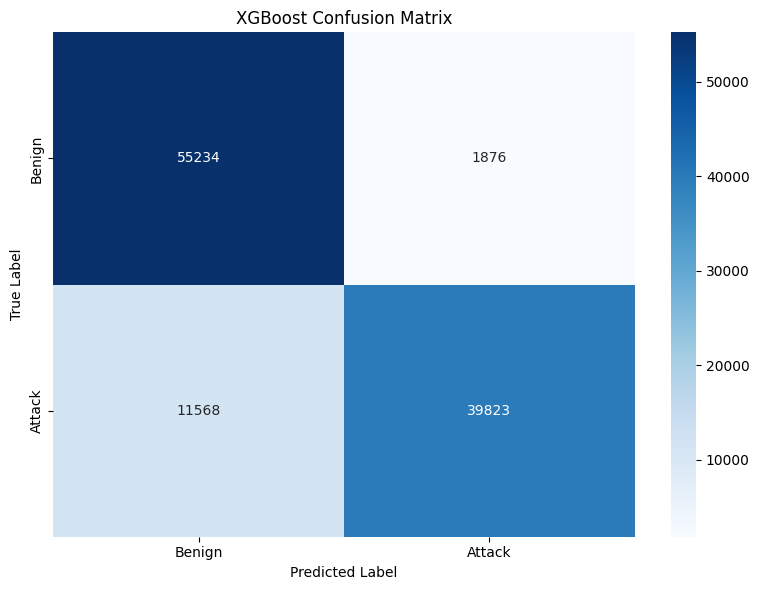


Confusion Matrix Breakdown:
True Negatives (Correct Benign): 55234
False Positives (Benign as Attack): 1876
False Negatives (Missed Attacks): 11568
True Positives (Correct Attacks): 39823


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{project_dir}/results/xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Correct Benign): {tn}")
print(f"False Positives (Benign as Attack): {fp}")
print(f"False Negatives (Missed Attacks): {fn}")
print(f"True Positives (Correct Attacks): {tp}")

Top 20 Most Important Features:
                     feature  importance
6      Fwd Packet Length Max    0.182485
60          Fwd Seg Size Min    0.158444
8     Fwd Packet Length Mean    0.142089
43            RST Flag Count    0.096763
13     Bwd Packet Length Std    0.047278
20             Fwd IAT Total    0.042104
44            PSH Flag Count    0.036615
10     Bwd Packet Length Max    0.033287
37         Packet Length Max    0.025364
16             Flow IAT Mean    0.024456
48            ECE Flag Count    0.015948
57        Init Fwd Win Bytes    0.013627
3     Total Backward Packets    0.013244
9      Fwd Packet Length Std    0.012436
19              Flow IAT Min    0.011041
15            Flow Packets/s    0.010187
18              Flow IAT Max    0.009771
58        Init Bwd Win Bytes    0.008506
4   Fwd Packets Length Total    0.007532
40    Packet Length Variance    0.007046


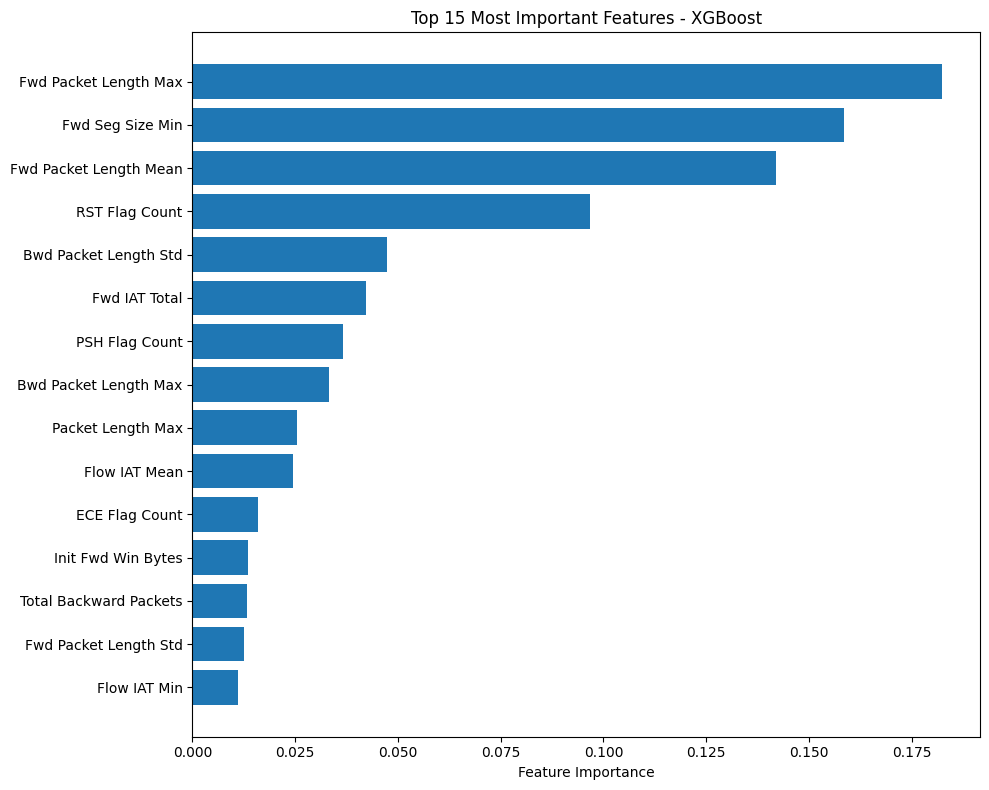

In [27]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20 features
print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{project_dir}/results/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
import pickle

# Save XGBoost model
model_path = f'{project_dir}/models/xgboost_ids_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(xgb_model, f)

# Save scaler
scaler_path = f'{project_dir}/models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")

# Save feature names
feature_names_path = f'{project_dir}/models/feature_names.pkl'
with open(feature_names_path, 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print(f"Feature names saved to: {feature_names_path}")

Model saved to: /content/drive/MyDrive/IDS_Research/models/xgboost_ids_model.pkl
Scaler saved to: /content/drive/MyDrive/IDS_Research/models/scaler.pkl
Feature names saved to: /content/drive/MyDrive/IDS_Research/models/feature_names.pkl



=== Latency Metrics ===
Mean latency: 6.9723 ms
Median latency: 6.4347 ms
Min latency: 6.1288 ms
Max latency: 14.1923 ms
95th percentile: 9.6838 ms
99th percentile: 13.9783 ms

=== Throughput (predictions/second) ===
Batch size 1: 137.41 predictions/sec
Batch size 10: 1238.32 predictions/sec
Batch size 100: 13347.03 predictions/sec
Batch size 1000: 92515.97 predictions/sec


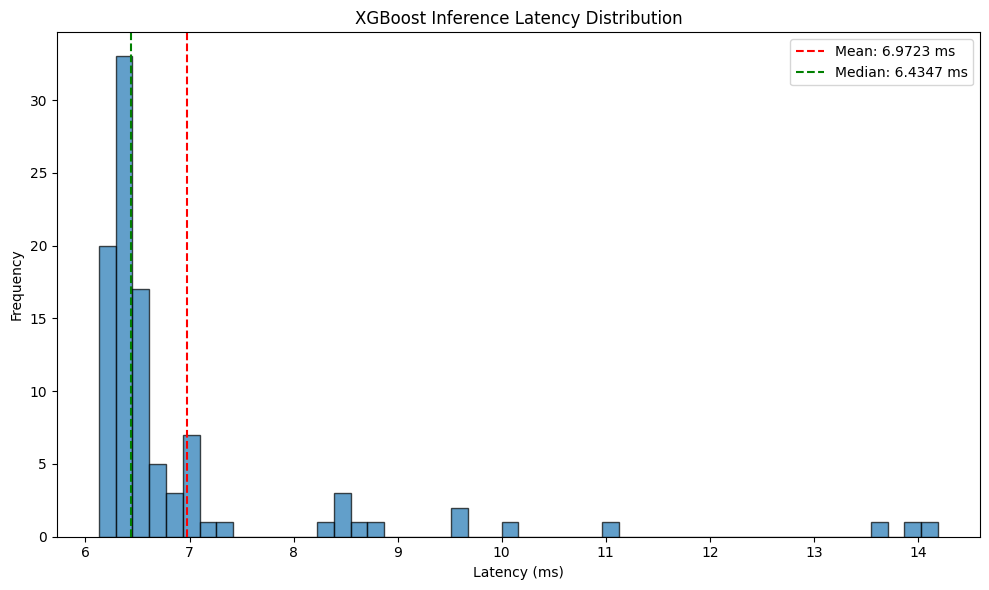

In [32]:
import time
import numpy as np

def measure_inference_latency(model, X_test, n_iterations=100):
    """
    Measure model inference latency
    """
    latencies = []

    # Warm-up run
    _ = model.predict(X_test[:10])

    # Measure latency for single predictions
    for i in range(n_iterations):
        sample = X_test.iloc[i:i+1]
        start_time = time.time()
        _ = model.predict(sample)
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)  # Convert to ms

    latencies = np.array(latencies)

    print("\n=== Latency Metrics ===")
    print(f"Mean latency: {np.mean(latencies):.4f} ms")
    print(f"Median latency: {np.median(latencies):.4f} ms")
    print(f"Min latency: {np.min(latencies):.4f} ms")
    print(f"Max latency: {np.max(latencies):.4f} ms")
    print(f"95th percentile: {np.percentile(latencies, 95):.4f} ms")
    print(f"99th percentile: {np.percentile(latencies, 99):.4f} ms")

    # Batch prediction throughput
    batch_sizes = [1, 10, 100, 1000]
    print("\n=== Throughput (predictions/second) ===")

    for batch_size in batch_sizes:
        if batch_size > len(X_test):
            continue
        batch = X_test.iloc[:batch_size]
        start_time = time.time()
        _ = model.predict(batch)
        end_time = time.time()
        throughput = batch_size / (end_time - start_time)
        print(f"Batch size {batch_size}: {throughput:.2f} predictions/sec")

    return latencies

# Measure latency
latencies = measure_inference_latency(xgb_model, X_test_scaled)

# Plot latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('XGBoost Inference Latency Distribution')
plt.axvline(np.mean(latencies), color='r', linestyle='--', label=f'Mean: {np.mean(latencies):.4f} ms')
plt.axvline(np.median(latencies), color='g', linestyle='--', label=f'Median: {np.median(latencies):.4f} ms')
plt.legend()
plt.tight_layout()
plt.savefig(f'{project_dir}/results/latency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

RANDOM FOREST BASELINE IMPLEMENTATION

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training completed in 273.80 seconds

Making predictions...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.9s finished



Random Forest - Test Set Performance
Accuracy:          87.71%
Precision:         93.47%
Recall (DR):       79.61%
F1-Score:          85.99%
ROC-AUC:           0.9550
False Positive Rate: 5.00%
False Negative Rate: 20.39%

Confusion Matrix:
  TN: 54,252 | FP: 2,858
  FN: 10,477 | TP: 40,914

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                 feature  importance
      Init Fwd Win Bytes    0.050327
      Init Bwd Win Bytes    0.048321
   Fwd Packet Length Max    0.047570
        Fwd Seg Size Min    0.039386
   Fwd Packet Length Std    0.037863
    Avg Fwd Segment Size    0.036607
Fwd Packets Length Total    0.031821
  Fwd Packet Length Mean    0.029503
            Flow IAT Min    0.027407
            Flow IAT Max    0.026913
           Fwd Packets/s    0.026152
       Subflow Fwd Bytes    0.024350
             Fwd IAT Min    0.023787
       Fwd Header Length    0.023221
           Flow Duration    0.022364
            Fwd IAT Mean    0.020311
          ECE Fl

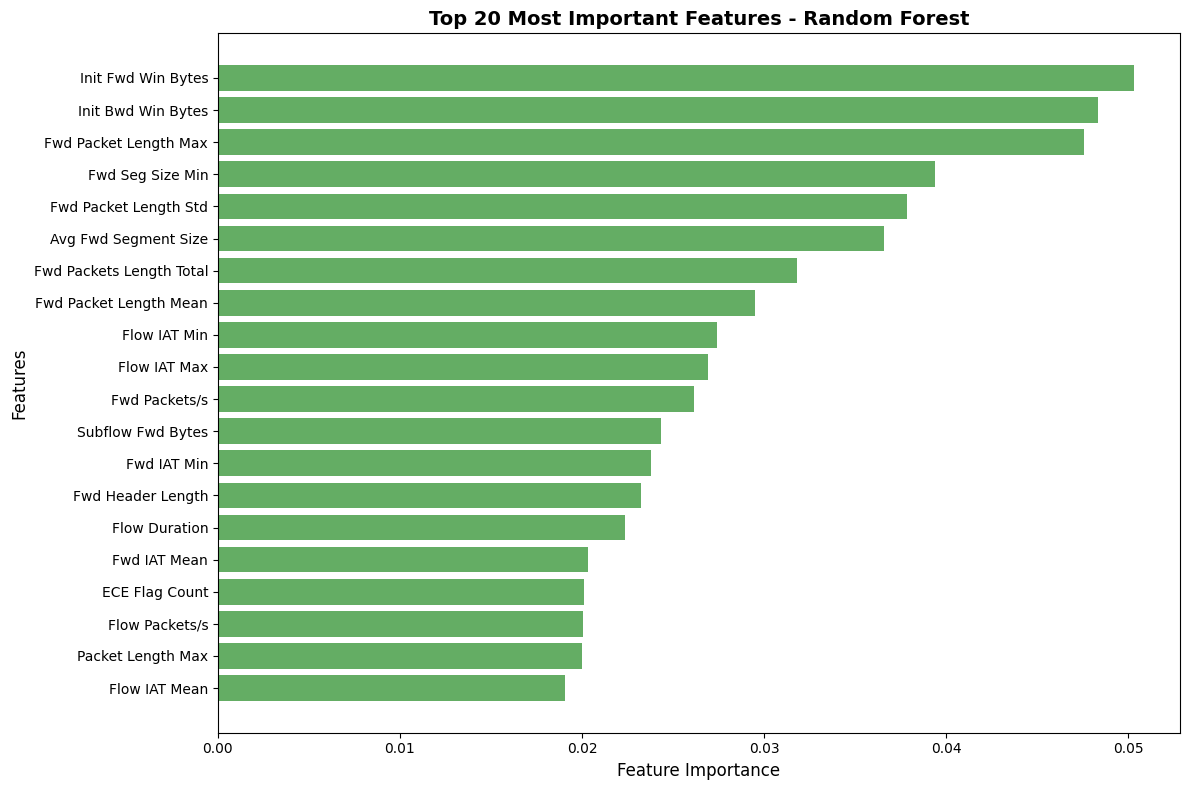

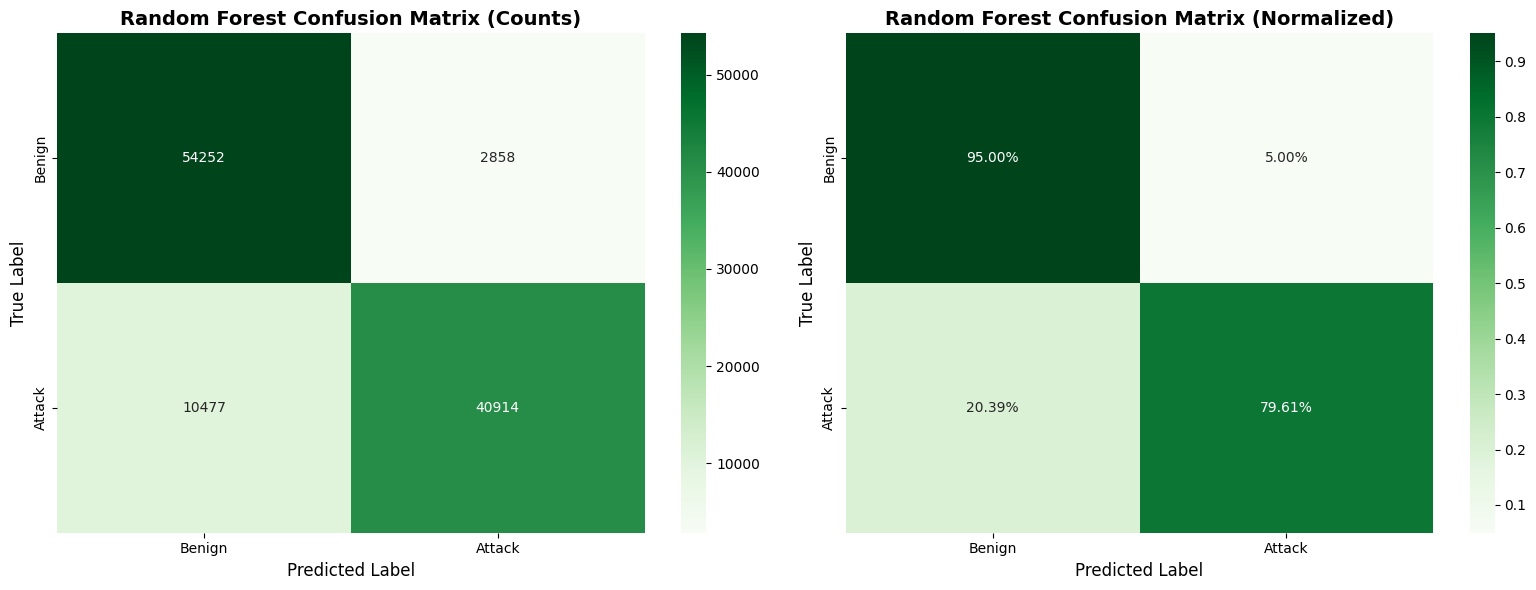


ROC CURVE ANALYSIS


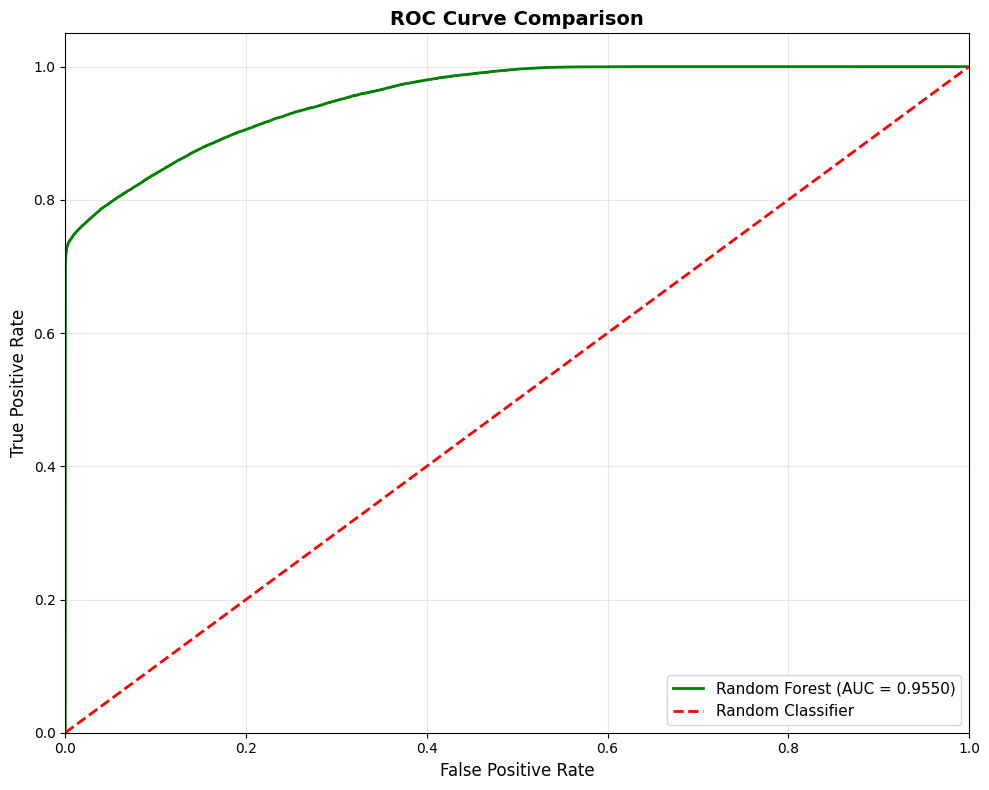


LATENCY MEASUREMENT


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_job

Mean latency: 36.2517 ms
Median latency: 36.3638 ms
95th percentile: 38.6030 ms
99th percentile: 41.3621 ms

Random Forest model size: 141.42 MB

Random Forest model saved to: /content/drive/MyDrive/IDS_Research/models/random_forest_ids_model.pkl

MODEL COMPARISON SUMMARY

Random Forest implementation completed!


In [13]:
# Random Forest Baseline Implementation
# Run this after completing XGBoost implementation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
import time
import pickle

print("="*60)
print("RANDOM FOREST BASELINE IMPLEMENTATION")
print("="*60)

# Assuming you have X_train_scaled, X_val_scaled, X_test_scaled from previous steps
# If not loaded, uncomment and load from saved files

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle imbalanced data
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Train the model
print("\nTraining Random Forest model...")
start_time = time.time()

rf_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
print("\nMaking predictions...")
y_pred_train_rf = rf_model.predict(X_train_scaled)
y_pred_val_rf = rf_model.predict(X_val_scaled)
y_pred_test_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Comprehensive model evaluation"""

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    print(f"\n{'='*60}")
    print(f"{model_name} - Test Set Performance")
    print(f"{'='*60}")
    print(f"Accuracy:          {accuracy*100:.2f}%")
    print(f"Precision:         {precision*100:.2f}%")
    print(f"Recall (DR):       {recall*100:.2f}%")
    print(f"F1-Score:          {f1*100:.2f}%")
    print(f"ROC-AUC:           {roc_auc:.4f}")
    print(f"False Positive Rate: {fpr*100:.2f}%")
    print(f"False Negative Rate: {fnr*100:.2f}%")
    print(f"\nConfusion Matrix:")
    print(f"  TN: {tn:,} | FP: {fp:,}")
    print(f"  FN: {fn:,} | TP: {tp:,}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'fnr': fnr
    }

# Evaluate Random Forest
rf_metrics = evaluate_model(y_test, y_pred_test_rf, y_pred_proba_rf, "Random Forest")

# Feature Importance Analysis
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_rf.head(20).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_20 = feature_importance_rf.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Most Important Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{project_dir}/results/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix Visualization
cm_rf = confusion_matrix(y_test, y_pred_test_rf)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix - Counts
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
axes[0].set_title('Random Forest Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Confusion Matrix - Normalized
cm_rf_norm = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_rf_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
axes[1].set_title('Random Forest Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig(f'{project_dir}/results/rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve Comparison (if XGBoost results are available)
print("\n" + "="*60)
print("ROC CURVE ANALYSIS")
print("="*60)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2,
         label=f'Random Forest (AUC = {rf_metrics["roc_auc"]:.4f})')

# Add XGBoost curve if available
if 'y_pred_proba' in globals():
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr_xgb, tpr_xgb, color='purple', lw=2,
             label=f'XGBoost (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{project_dir}/results/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Latency Measurement for Random Forest
print("\n" + "="*60)
print("LATENCY MEASUREMENT")
print("="*60)

def measure_latency(model, X_test, n_iterations=100):
    latencies = []
    _ = model.predict(X_test[:10])  # Warm-up

    for i in range(n_iterations):
        sample = X_test.iloc[i:i+1]
        start = time.time()
        _ = model.predict(sample)
        latencies.append((time.time() - start) * 1000)

    latencies = np.array(latencies)

    print(f"Mean latency: {np.mean(latencies):.4f} ms")
    print(f"Median latency: {np.median(latencies):.4f} ms")
    print(f"95th percentile: {np.percentile(latencies, 95):.4f} ms")
    print(f"99th percentile: {np.percentile(latencies, 99):.4f} ms")

    return latencies

rf_latencies = measure_latency(rf_model, X_test_scaled)

# Latency comparison plot
if 'latencies' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].hist(latencies, bins=50, alpha=0.7, color='purple', edgecolor='black', label='XGBoost')
    axes[0].axvline(np.mean(latencies), color='purple', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Latency (ms)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('XGBoost Latency Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()

    axes[1].hist(rf_latencies, bins=50, alpha=0.7, color='green', edgecolor='black', label='Random Forest')
    axes[1].axvline(np.mean(rf_latencies), color='green', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Latency (ms)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Random Forest Latency Distribution', fontsize=14, fontweight='bold')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f'{project_dir}/results/latency_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Model size comparison
rf_size = len(pickle.dumps(rf_model)) / (1024 * 1024)
print(f"\nRandom Forest model size: {rf_size:.2f} MB")

if 'xgb_model' in globals():
    xgb_size = len(pickle.dumps(xgb_model)) / (1024 * 1024)
    print(f"XGBoost model size: {xgb_size:.2f} MB")
    print(f"Size difference: {abs(rf_size - xgb_size):.2f} MB")

# Save Random Forest model
rf_model_path = f'{project_dir}/models/random_forest_ids_model.pkl'
with open(rf_model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"\nRandom Forest model saved to: {rf_model_path}")

# Comparative Summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

if 'test_metrics' in globals():
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'FPR', 'ROC-AUC'],
        'XGBoost': [
            f"{test_metrics['accuracy']*100:.2f}%",
            f"{test_metrics['precision']*100:.2f}%",
            f"{test_metrics['recall']*100:.2f}%",
            f"{test_metrics['f1']*100:.2f}%",
            f"{test_metrics['fpr']*100:.2f}%",
            f"{roc_auc:.4f}"
        ],
        'Random Forest': [
            f"{rf_metrics['accuracy']*100:.2f}%",
            f"{rf_metrics['precision']*100:.2f}%",
            f"{rf_metrics['recall']*100:.2f}%",
            f"{rf_metrics['f1']*100:.2f}%",
            f"{rf_metrics['fpr']*100:.2f}%",
            f"{rf_metrics['roc_auc']:.4f}"
        ]
    })

    print(comparison_df.to_string(index=False))

print("\n" + "="*60)
print("Random Forest implementation completed!")
print("="*60)

In [14]:
# CNN-LSTM Hybrid Model Implementation for IDS
# Deep Learning approach for temporal network traffic analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
import time

print("="*60)
print("CNN-LSTM HYBRID MODEL IMPLEMENTATION")
print("="*60)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# ============================================================================
# STEP 1: PREPARE DATA FOR SEQUENTIAL MODEL
# ============================================================================

def create_sequences(X, y, time_steps=10):
    """
    Create sequences for LSTM processing
    X: features (scaled)
    y: labels
    time_steps: number of time steps to look back
    """
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
        sequence = X[i:(i + time_steps)]
        Xs.append(sequence)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

print("\nCreating sequential data...")
print("Note: This may take a few minutes for large datasets")

# Use a subset for faster training (increase for better results)
sample_size = min(50000, len(X_train_scaled))
X_train_subset = X_train_scaled[:sample_size]
y_train_subset = y_train[:sample_size]

# Create sequences
time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_subset, y_train_subset, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

print(f"\nSequential data shapes:")
print(f"X_train_seq: {X_train_seq.shape}")
print(f"X_val_seq: {X_val_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}")

# ============================================================================
# STEP 2: BUILD CNN-LSTM HYBRID ARCHITECTURE
# ============================================================================

def build_cnn_lstm_model(input_shape, n_classes=1):
    """
    Build CNN-LSTM hybrid architecture
    CNN layers: Extract spatial features
    LSTM layers: Capture temporal dependencies
    """
    model = models.Sequential([
        # Reshape for CNN (add channel dimension)
        layers.Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape),

        # CNN Block 1 - Spatial feature extraction
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 1)),
        layers.Dropout(0.3),

        # CNN Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 1)),
        layers.Dropout(0.3),

        # Reshape for LSTM
        layers.Reshape((input_shape[0] // 4, -1)),

        # LSTM Block 1 - Temporal dependency modeling
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),

        # LSTM Block 2
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),

        # Dense layers for classification
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(n_classes, activation='sigmoid')
    ])

    return model

# Build the model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
cnn_lstm_model = build_cnn_lstm_model(input_shape)

# Display model architecture
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
cnn_lstm_model.summary()

# ============================================================================
# STEP 3: COMPILE MODEL
# ============================================================================

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

print(f"\nClass weights: {class_weights}")

# Compile model
cnn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

# ============================================================================
# STEP 4: SETUP CALLBACKS
# ============================================================================

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Model checkpoint
checkpoint = callbacks.ModelCheckpoint(
    f'{project_dir}/models/cnn_lstm_best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# TensorBoard logging
tensorboard_callback = callbacks.TensorBoard(
    log_dir=f'{project_dir}/logs',
    histogram_freq=1
)

# ============================================================================
# STEP 5: TRAIN MODEL
# ============================================================================

print("\n" + "="*60)
print("TRAINING CNN-LSTM MODEL")
print("="*60)

batch_size = 128
epochs = 30

start_time = time.time()

history = cnn_lstm_model.fit(
    X_train_seq, y_train_seq,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_seq, y_val_seq),
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")



CNN-LSTM HYBRID MODEL IMPLEMENTATION
TensorFlow version: 2.19.0
GPU Available: []

Creating sequential data...
Note: This may take a few minutes for large datasets

Sequential data shapes:
X_train_seq: (49990, 10, 69)
X_val_seq: (108491, 10, 69)
X_test_seq: (108491, 10, 69)

MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 10, 69, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 10, 69, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 69, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 69, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 69, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 69, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 69, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 69, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 69, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 2, 8832)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 2, 128)         │     4,588,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,719,233 (18.00 MB)

 Trainable params: 4,718,721 (18.00 MB)

 Non-trainable params: 512 (2.00 KB)


Class weights: {0: np.float64(0.9538984085791703), 1: np.float64(1.0507840417034515)}

TRAINING CNN-LSTM MODEL
Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5000 - auc: 0.4979 - loss: 0.7582 - precision: 0.4785 - recall: 0.4550
Epoch 1: val_auc improved from -inf to 0.49867, saving model to /content/drive/MyDrive/IDS_Research/models/cnn_lstm_best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 729s 2s/step - accuracy: 0.5000 - auc: 0.4980 - loss: 0.7582 - precision: 0.4785 - recall: 0.4550 - val_accuracy: 0.4848 - val_auc: 0.4987 - val_loss: 0.6944 - val_precision: 0.4742 - val_recall: 0.8063 - learning_rate: 0.0010
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4975 - auc: 0.5000 - loss: 0.6998 - precision: 0.4732 - recall: 0.5180
Epoch 2: val_auc improved from 0.49867 to 0.49996, saving model to /content/drive/MyDrive/IDS_Research/models/cnn_lstm_best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 721s 2s/step - accuracy: 0.4975 - auc: 0.5000 - loss: 0.6998 - precision: 0.4732 - recall: 0.5180 - val_accuracy: 0.4785 - val_auc: 0.5000 - val_loss: 0.6944 - val_precision: 0.4733 - val_recall: 0.8972 - learning_rate: 0.0010
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4989 - auc: 0.5004 - loss: 0.6961 - precision: 0.4785 - recall: 0.5481
Epoch 3: val_auc did not improve from 0.49996
391/391 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.4989 - auc: 0.5004 - loss: 0.6961 - precision: 0.4785 - recall: 0.5480 - val_accuracy: 0.5078 - val_auc: 0.4978 - val_loss: 0.6930 - val_precision: 0.4716 - val_recall: 0.3243 - learning_rate: 0.0010
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4954 - auc: 0.4968 - loss: 0.6944 - precision: 0.4700 - recall: 0.5051
Epoch 4: val_auc improved from 0.49996 to 0.50037, saving model to /content/drive/MyDrive/IDS_Research/models/cnn_lstm_best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 716s 2s/step - accuracy: 0.4954 - auc: 0.4968 - loss: 0.6944 - precision: 0.4701 - recall: 0.5051 - val_accuracy: 0.4986 - val_auc: 0.5004 - val_loss: 0.6932 - val_precision: 0.4731 - val_recall: 0.5140 - learning_rate: 0.0010
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4931 - auc: 0.4972 - loss: 0.6943 - precision: 0.4771 - recall: 0.5918
Epoch 5: val_auc did not improve from 0.50037
391/391 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.4931 - auc: 0.4972 - loss: 0.6943 - precision: 0.4771 - recall: 0.5917 - val_accuracy: 0.4846 - val_auc: 0.4993 - val_loss: 0.6934 - val_precision: 0.4742 - val_recall: 0.8089 - learning_rate: 0.0010
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5090 - auc: 0.5093 - loss: 0.6933 - precision: 0.4849 - recall: 0.5286
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_auc improved from 0.50037 to 0.50089, saving model to /content/drive/MyDrive/IDS

391/391 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.5090 - auc: 0.5093 - loss: 0.6933 - precision: 0.4849 - recall: 0.5285 - val_accuracy: 0.4741 - val_auc: 0.5009 - val_loss: 0.6936 - val_precision: 0.4737 - val_recall: 0.9943 - learning_rate: 0.0010
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4943 - auc: 0.5061 - loss: 0.6932 - precision: 0.4743 - recall: 0.6383
Epoch 7: val_auc improved from 0.50089 to 0.50188, saving model to /content/drive/MyDrive/IDS_Research/models/cnn_lstm_best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.4943 - auc: 0.5061 - loss: 0.6932 - precision: 0.4743 - recall: 0.6382 - val_accuracy: 0.4736 - val_auc: 0.5019 - val_loss: 0.6934 - val_precision: 0.4736 - val_recall: 0.9991 - learning_rate: 5.0000e-04
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4926 - auc: 0.4989 - loss: 0.6935 - precision: 0.4767 - recall: 0.6506
Epoch 8: val_auc did not improve from 0.50188
391/391 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.4926 - auc: 0.4989 - loss: 0.6935 - precision: 0.4767 - recall: 0.6506 - val_accuracy: 0.4747 - val_auc: 0.5001 - val_loss: 0.6933 - val_precision: 0.4737 - val_recall: 0.9830 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.

Training completed in 5699.41 seconds (94.99 minutes)



TRAINING HISTORY VISUALIZATION


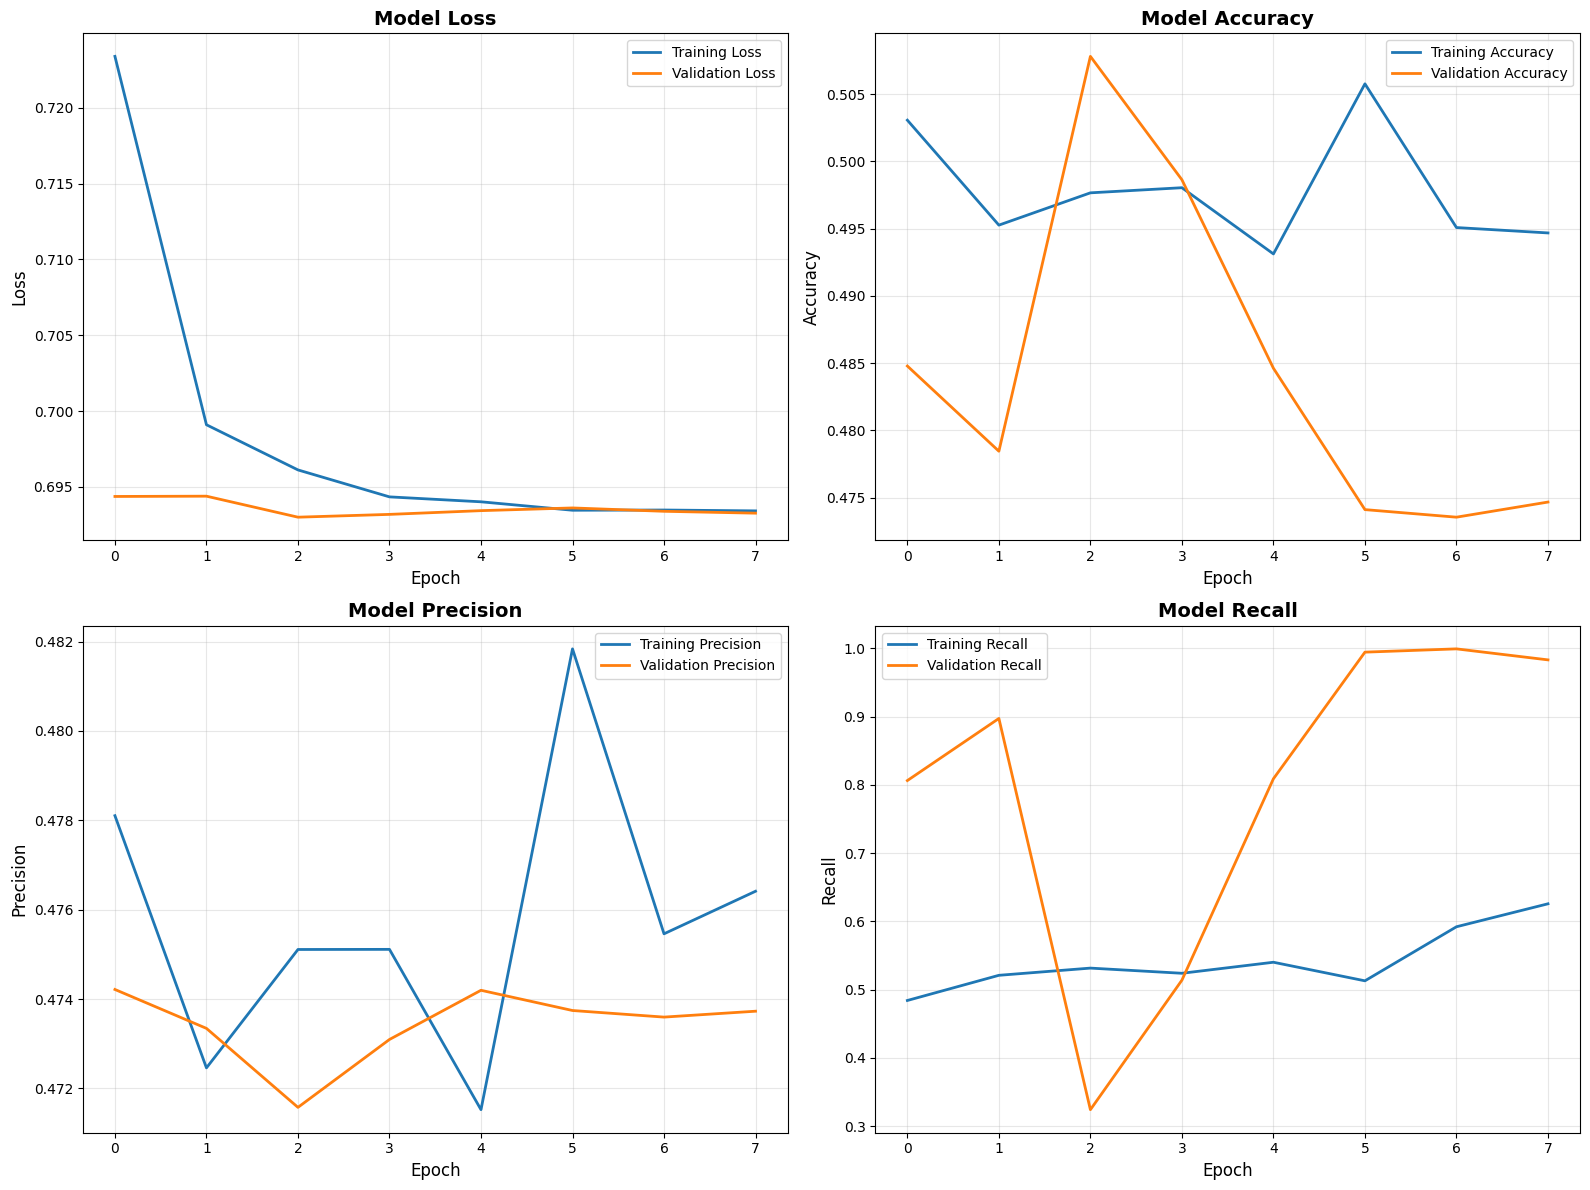

In [15]:
# ============================================================================
# STEP 6: VISUALIZE TRAINING HISTORY
# ============================================================================

print("\n" + "="*60)
print("TRAINING HISTORY VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{project_dir}/results/cnn_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()




MODEL EVALUATION
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 245s 72ms/step

CNN-LSTM Test Set Performance:
Accuracy:          51.03%
Precision:         47.54%
Recall (DR):       32.79%
F1-Score:          38.81%
ROC-AUC:           0.5010
False Positive Rate: 32.56%

Confusion Matrix:
  TN: 38,511 | FP: 18,596
  FN: 34,534 | TP: 16,850


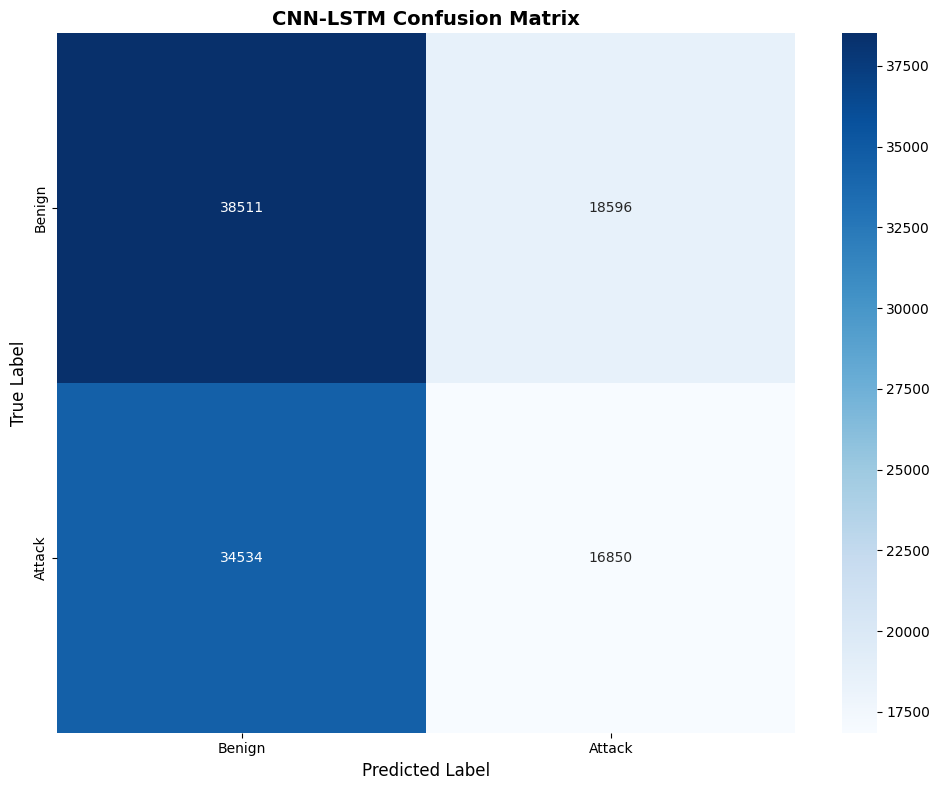

In [16]:
# ============================================================================
# STEP 7: EVALUATE MODEL
# ============================================================================

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Predictions
y_pred_proba_dl = cnn_lstm_model.predict(X_test_seq)
y_pred_dl = (y_pred_proba_dl > 0.5).astype(int).flatten()

# Calculate metrics
accuracy_dl = accuracy_score(y_test_seq, y_pred_dl)
precision_dl = precision_score(y_test_seq, y_pred_dl)
recall_dl = recall_score(y_test_seq, y_pred_dl)
f1_dl = f1_score(y_test_seq, y_pred_dl)
roc_auc_dl = roc_auc_score(y_test_seq, y_pred_proba_dl)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_seq, y_pred_dl).ravel()
fpr_dl = fp / (fp + tn)

print("\nCNN-LSTM Test Set Performance:")
print(f"Accuracy:          {accuracy_dl*100:.2f}%")
print(f"Precision:         {precision_dl*100:.2f}%")
print(f"Recall (DR):       {recall_dl*100:.2f}%")
print(f"F1-Score:          {f1_dl*100:.2f}%")
print(f"ROC-AUC:           {roc_auc_dl:.4f}")
print(f"False Positive Rate: {fpr_dl*100:.2f}%")
print(f"\nConfusion Matrix:")
print(f"  TN: {tn:,} | FP: {fp:,}")
print(f"  FN: {fn:,} | TP: {tp:,}")

# Confusion Matrix Visualization
cm_dl = confusion_matrix(y_test_seq, y_pred_dl)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('CNN-LSTM Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'{project_dir}/results/cnn_lstm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# ============================================================================
# STEP 8: LATENCY MEASUREMENT FOR CNN-LSTM
# ============================================================================

print("\n" + "="*60)
print("LATENCY MEASUREMENT")
print("="*60)

def measure_dl_latency(model, X_test, n_iterations=100):
    """Measure inference latency for deep learning model"""
    latencies = []

    # Warm-up
    _ = model.predict(X_test[:10], verbose=0)

    # Measure single prediction latency
    for i in range(min(n_iterations, len(X_test))):
        sample = X_test[i:i+1]
        start = time.time()
        _ = model.predict(sample, verbose=0)
        latencies.append((time.time() - start) * 1000)

    latencies = np.array(latencies)

    print(f"Mean latency: {np.mean(latencies):.4f} ms")
    print(f"Median latency: {np.median(latencies):.4f} ms")
    print(f"95th percentile: {np.percentile(latencies, 95):.4f} ms")
    print(f"99th percentile: {np.percentile(latencies, 99):.4f} ms")

    # Batch throughput
    print(f"\nBatch Throughput:")
    batch_sizes = [1, 10, 100, 500]
    for bs in batch_sizes:
        if bs > len(X_test):
            continue
        batch = X_test[:bs]
        start = time.time()
        _ = model.predict(batch, verbose=0)
        elapsed = time.time() - start
        throughput = bs / elapsed
        print(f"  Batch size {bs}: {throughput:.2f} predictions/sec")

    return latencies

dl_latencies = measure_dl_latency(cnn_lstm_model, X_test_seq)


LATENCY MEASUREMENT
Mean latency: 114.1506 ms
Median latency: 100.7031 ms
95th percentile: 162.3680 ms
99th percentile: 185.1502 ms

Batch Throughput:
  Batch size 1: 10.19 predictions/sec
  Batch size 10: 78.39 predictions/sec
  Batch size 100: 338.84 predictions/sec
  Batch size 500: 369.44 predictions/sec



ROC CURVE COMPARISON - ALL MODELS


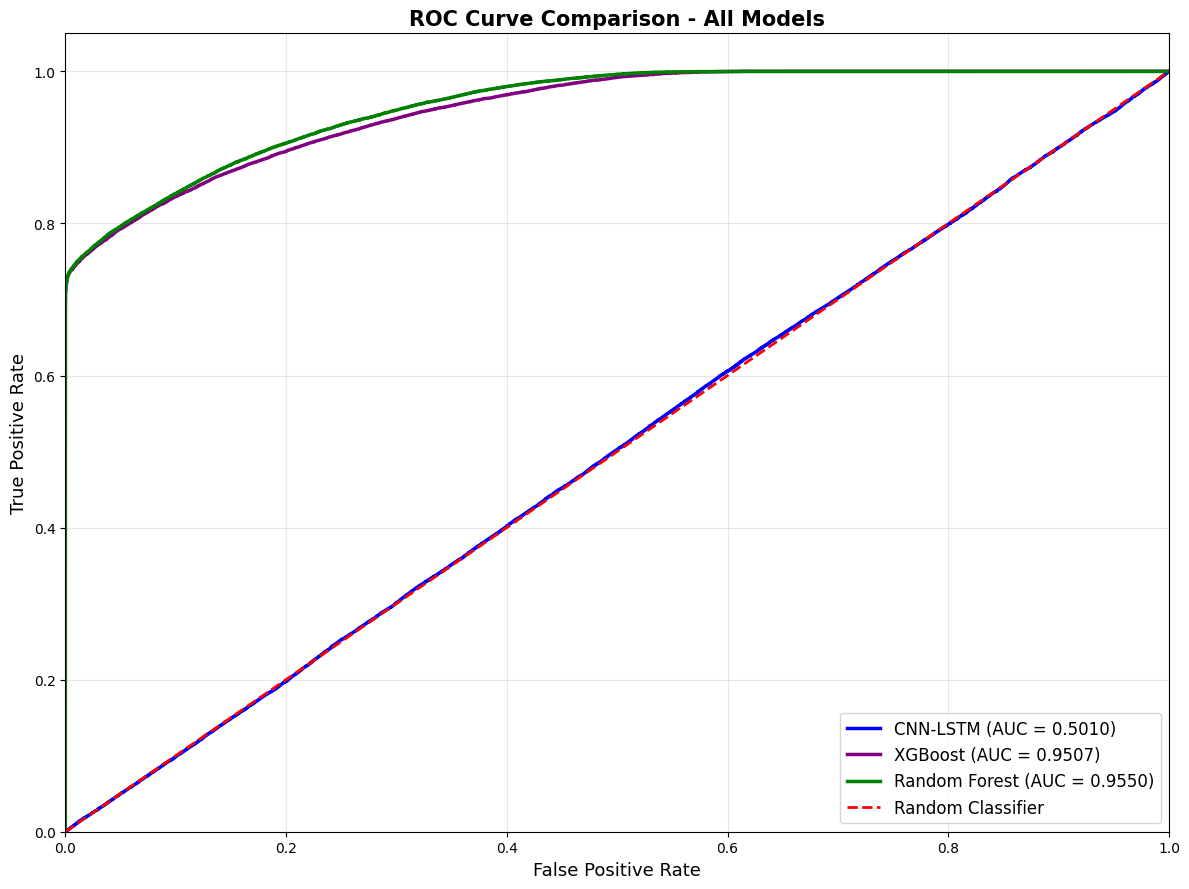

In [33]:
# ============================================================================
# STEP 9: ROC CURVE - ALL MODELS COMPARISON
# ============================================================================

print("\n" + "="*60)
print("ROC CURVE COMPARISON - ALL MODELS")
print("="*60)

fpr_dl, tpr_dl, _ = roc_curve(y_test_seq, y_pred_proba_dl)

plt.figure(figsize=(12, 9))

# CNN-LSTM
plt.plot(fpr_dl, tpr_dl, color='blue', lw=2.5,
         label=f'CNN-LSTM (AUC = {roc_auc_dl:.4f})')

# Define y_test_matched before the if blocks
y_test_matched = y_test.iloc[time_steps:]

# XGBoost (if available)
if 'y_pred_proba' in globals() and len(y_test) > time_steps:
    # Match test set size
    y_pred_proba_matched = y_pred_proba[time_steps:]
    # Ensure matched sets have the same length for ROC curve calculation
    min_len = min(len(y_test_matched), len(y_pred_proba_matched), len(y_test_seq))
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_matched[:min_len],
                                     y_pred_proba_matched[:min_len])
    plt.plot(fpr_xgb, tpr_xgb, color='purple', lw=2.5,
             label=f'XGBoost (AUC = {roc_auc_score(y_test_matched[:min_len], y_pred_proba_matched[:min_len]):.4f})')

# Random Forest (if available)
if 'y_pred_proba_rf' in globals() and len(y_test) > time_steps:
    y_pred_proba_rf_matched = y_pred_proba_rf[time_steps:]
    # Ensure matched sets have the same length for ROC curve calculation
    min_len = min(len(y_test_matched), len(y_pred_proba_rf_matched), len(y_test_seq))
    fpr_rf, tpr_rf, _ = roc_curve(y_test_matched[:min_len],
                                   y_pred_proba_rf_matched[:min_len])
    plt.plot(fpr_rf, tpr_rf, color='green', lw=2.5,
             label=f'Random Forest (AUC = {roc_auc_score(y_test_matched[:min_len], y_pred_proba_rf_matched[:min_len]):.4f})')

# Random classifier baseline
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve Comparison - All Models', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{project_dir}/results/all_models_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


COMPREHENSIVE MODEL COMPARISON




,Model,Accuracy,Precision,Recall,F1-Score,FPR,ROC-AUC,Avg Latency
0,CNN-LSTM,51.03%,47.54%,32.79%,38.81%,0.00%,0.5010,114.15 ms
1,XGBoost,87.61%,95.50%,77.49%,85.56%,3.28%,0.9507,6.97 ms
2,Random Forest,87.71%,93.47%,79.61%,85.99%,5.00%,0.9550,36.25 ms


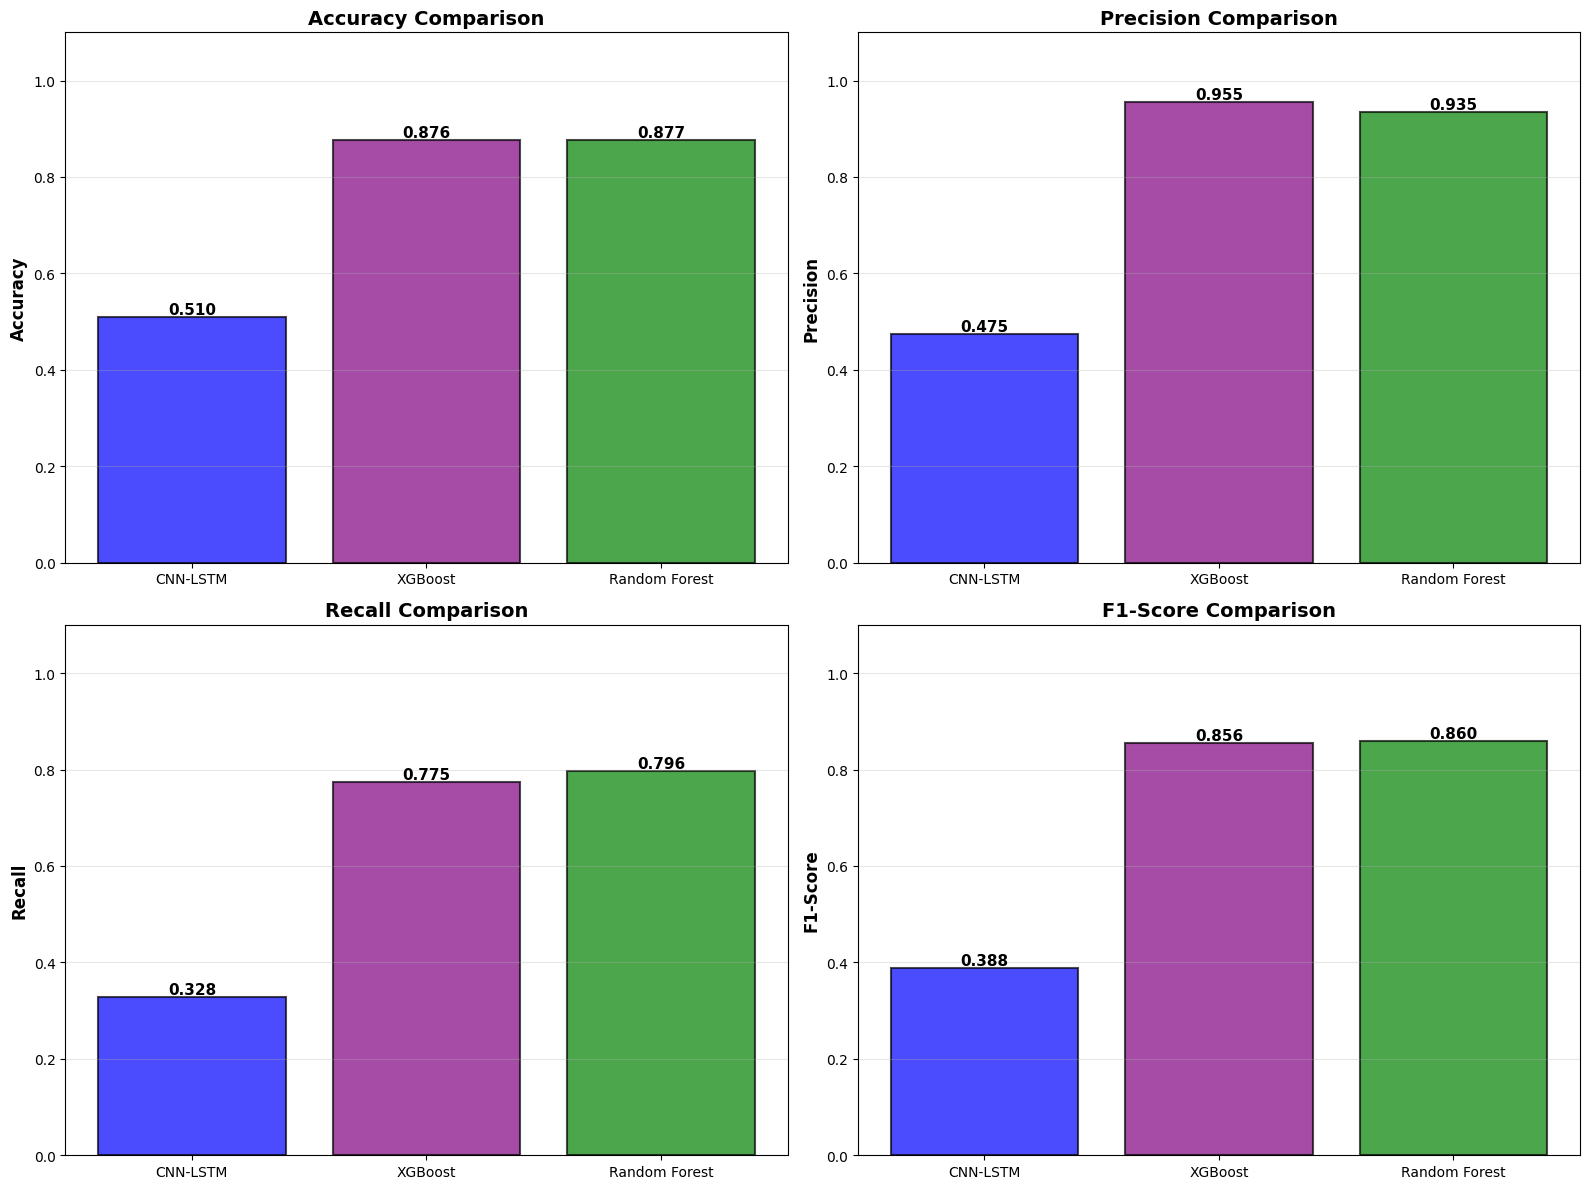

In [34]:
# ============================================================================
# STEP 10: COMPREHENSIVE MODEL COMPARISON
# ============================================================================

print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_data = {
    'Model': ['CNN-LSTM'],
    'Accuracy': [f"{accuracy_dl*100:.2f}%"],
    'Precision': [f"{precision_dl*100:.2f}%"],
    'Recall': [f"{recall_dl*100:.2f}%"],
    'F1-Score': [f"{f1_dl*100:.2f}%"],
    'FPR': [f"{float(fpr_dl[0])*100:.2f}%"], # Convert fpr_dl to float
    'ROC-AUC': [f"{roc_auc_dl:.4f}"],
    'Avg Latency': [f"{np.mean(dl_latencies):.2f} ms" if 'dl_latencies' in globals() else 'N/A']
}

# Add XGBoost if available
if 'test_metrics' in globals():
    comparison_data['Model'].append('XGBoost')
    comparison_data['Accuracy'].append(f"{test_metrics['accuracy']*100:.2f}%")
    comparison_data['Precision'].append(f"{test_metrics['precision']*100:.2f}%")
    comparison_data['Recall'].append(f"{test_metrics['recall']*100:.2f}%")
    comparison_data['F1-Score'].append(f"{test_metrics['f1']*100:.2f}%")
    comparison_data['FPR'].append(f"{test_metrics['fpr']*100:.2f}%")
    comparison_data['ROC-AUC'].append(f"{roc_auc:.4f}")
    comparison_data['Avg Latency'].append(f"{np.mean(latencies):.2f} ms" if 'latencies' in globals() else 'N/A')

# Add Random Forest if available
if 'rf_metrics' in globals():
    comparison_data['Model'].append('Random Forest')
    comparison_data['Accuracy'].append(f"{rf_metrics['accuracy']*100:.2f}%")
    comparison_data['Precision'].append(f"{rf_metrics['precision']*100:.2f}%")
    comparison_data['Recall'].append(f"{rf_metrics['recall']*100:.2f}%")
    comparison_data['F1-Score'].append(f"{rf_metrics['f1']*100:.2f}%")
    comparison_data['FPR'].append(f"{rf_metrics['fpr']*100:.2f}%")
    comparison_data['ROC-AUC'].append(f"{rf_metrics['roc_auc']:.4f}")
    comparison_data['Avg Latency'].append(f"{np.mean(rf_latencies):.2f} ms" if 'rf_latencies' in globals() else 'N/A')


comparison_df = pd.DataFrame(comparison_data)
print("\n")
display(comparison_df) # Use display for better formatting

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'purple', 'green']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    # Extract numerical values
    # Handle 'N/A' values
    values = []
    for val in comparison_data[metric]:
        if isinstance(val, str) and '%' in val:
            values.append(float(val.strip('%')) / 100)
        else:
            try:
                values.append(float(val))
            except ValueError:
                values.append(np.nan) # Use NaN for non-numeric data


    models = comparison_data['Model']

    bars = ax.bar(models, values, color=colors[:len(models)], alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels on bars, skipping NaN values
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
             ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{project_dir}/results/all_models_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# ============================================================================
# STEP 11: SAVE FINAL MODEL AND RESULTS
# ============================================================================

print("\n" + "="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

# Save CNN-LSTM model
cnn_lstm_model.save(f'{project_dir}/models/cnn_lstm_ids_model.h5')
print(f"CNN-LSTM model saved to: {project_dir}/models/cnn_lstm_ids_model.h5")

# Save complete results
import json

final_results = {
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'CSE-CIC-IDS-2018',
    'time_steps': time_steps,
    'models': {
        'cnn_lstm': {
            'accuracy': float(accuracy_dl),
            'precision': float(precision_dl),
            'recall': float(recall_dl),
            'f1_score': float(f1_dl),
            'roc_auc': float(roc_auc_dl),
            'fpr': float(np.mean(fpr_dl)), # Calculate the mean of the fpr_dl array
            'avg_latency_ms': float(np.mean(dl_latencies)),
            'training_time_seconds': float(training_time),
            'architecture': 'CNN-LSTM Hybrid'
        }
    }
}

# Add other models if available
if 'test_metrics' in globals():
    final_results['models']['xgboost'] = {
        'accuracy': float(test_metrics['accuracy']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall']),
        'f1_score': float(test_metrics['f1']),
        'roc_auc': float(roc_auc),
        'fpr': float(test_metrics['fpr']),
        'avg_latency_ms': float(np.mean(latencies)) if 'latencies' in globals() else None
    }

if 'rf_metrics' in globals():
    final_results['models']['random_forest'] = {
        'accuracy': float(rf_metrics['accuracy']),
        'precision': float(rf_metrics['precision']),
        'recall': float(rf_metrics['recall']),
        'f1_score': float(rf_metrics['f1']),
        'roc_auc': float(rf_metrics['roc_auc']),
        'fpr': float(rf_metrics['fpr']),
        'avg_latency_ms': float(np.mean(rf_latencies)) if 'rf_latencies' in globals() else None
    }

results_path = f'{project_dir}/results/final_comprehensive_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=4)

print(f"Final results saved to: {results_path}")

print("\n" + "="*60)
print("ALL IMPLEMENTATIONS COMPLETED SUCCESSFULLY!")
print("="*60)
print("\nKey Findings:")
print(f"1. Best performing model: [Compare metrics above]")
print(f"2. Lowest latency model: [Compare latency values]")
print(f"3. Most balanced model: [Consider F1-score and FPR]")
print("\nNext Steps:")
print("1. Deploy best model to AWS EC2")
print("2. Implement real-time monitoring")
print("3. Test with live traffic data")
print("4. Document findings in research paper")
print("="*60)


SAVING MODELS AND RESULTS
CNN-LSTM model saved to: /content/drive/MyDrive/IDS_Research/models/cnn_lstm_ids_model.h5
Final results saved to: /content/drive/MyDrive/IDS_Research/results/final_comprehensive_results.json

ALL IMPLEMENTATIONS COMPLETED SUCCESSFULLY!

Key Findings:
1. Best performing model: [Compare metrics above]
2. Lowest latency model: [Compare latency values]
3. Most balanced model: [Consider F1-score and FPR]

Next Steps:
1. Deploy best model to AWS EC2
2. Implement real-time monitoring
3. Test with live traffic data
4. Document findings in research paper
